<a href="https://colab.research.google.com/github/nickymind/DOE-Econometria/blob/main/Nowcasting_PIB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install statsmodels --upgrade
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [3]:
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd

# 1. Carga y ajuste de Series


In [4]:
pd.set_option('display.float_format',  '{:,}'.format)

In [5]:
trx=pd.read_csv('https://raw.githubusercontent.com/nickymind/DOE-Econometria/main/Data%20trx%20v2.csv', sep=';', encoding='latin-1')

In [6]:
trx.head()

,Periodo,Año,Fecha,N_Mes,S_ATM,Q_ATM,S_CAJA,Q_CAJA,S_TC,Q_TC,S_TD,Q_TD,S_Transf,Q_Transf
0,202109,2021,1/9/21 00:00,9,"2,470,454,581.65","364,868.0","1,343,225,437.97","11,584.0","108,162,943.57",25117,"970,780,164.47","383,681.0","2,566,476,688.9","192,309.0"
1,202109,2021,2/9/21 00:00,9,"2,548,740,104.56","369,785.0","1,412,150,557.47","11,110.0","85,539,020.98",20831,"977,337,373.0","389,395.0","2,570,610,668.03","192,484.0"
2,202109,2021,3/9/21 00:00,9,"2,790,571,218.86","390,939.0","1,912,946,253.56","14,220.0","91,824,075.48",23344,"1,099,383,834.02","433,393.0","2,816,008,441.9","212,779.0"
3,202109,2021,4/9/21 00:00,9,NaN,NaN,NaN,NaN,"79,277,854.42",19693,"1,120,945,104.32","439,813.0",NaN,NaN
4,202109,2021,5/9/21 00:00,9,NaN,NaN,NaN,NaN,"40,059,232.11",11549,"540,123,107.94","253,641.0",NaN,NaN


In [14]:
emae=pd.read_csv('https://raw.githubusercontent.com/nickymind/DOE-Econometria/Ajustes/EMAEv2.csv', sep=',', encoding='latin-1')

In [15]:
emae.head()

,Periodo,Indice
0,202108,141.058025135032
1,202109,140.845981271007
2,202110,140.562729892158
3,202111,145.463587294665
4,202112,146.03073105734


In [9]:
trx.drop(trx.index[trx['Periodo'] == 202211], inplace=True)

In [10]:
trx.drop(trx.index[trx['Periodo'] == 202212], inplace=True)

In [11]:
trx.drop(trx.index[trx['Periodo'] == 202301], inplace=True)

In [16]:
emae.drop(emae.index[emae['Periodo'] == 202108], inplace=True)

In [17]:
trx_agrupmes=trx.groupby(['Periodo']).sum()

In [18]:
trx_agrupmes.head()

,Año,N_Mes,S_ATM,Q_ATM,S_CAJA,Q_CAJA,S_TC,Q_TC,S_TD,Q_TD,S_Transf,Q_Transf
Periodo,,,,,,,,,,,,
202109,60630,270,"58,789,743,679.19","8,916,269.0","33,535,452,807.72","280,631.0","13,916,704,537.6",3362919,"24,503,367,623.97","10,565,832.0","54,505,185,542.46","4,425,462.0"
202110,62651,310,"59,397,794,926.83","8,758,404.0","34,518,749,819.22","278,723.0","28,145,229,157.34",6147408,"28,134,615,010.62","11,950,886.0","54,245,880,146.11","3,747,904.0"
202111,60630,330,"68,553,238,783.200005","9,508,422.0","37,915,961,677.52","292,272.0","29,638,326,822.18",5640658,"28,124,349,814.32","11,593,239.0","57,215,729,678.06","3,922,719.0"
202112,62651,372,"88,879,461,348.04","10,931,282.0","51,635,687,934.84","376,705.0","30,148,240,607.22",5745105,"39,295,148,363.03","14,589,180.0","68,186,780,263.59","4,460,891.0"
202201,62682,31,"69,931,623,292.08","8,676,702.0","31,704,018,266.0","249,572.0","26,206,466,771.23",5037420,"32,017,977,035.78","12,190,170.0","60,336,773,062.16","3,812,772.0"


In [19]:
trx_agrupmes.reset_index(inplace=True)

In [ ]:
trx_agrupmes.info()

In [ ]:
emae.info()

In [23]:
assert set(emae.Periodo) == set(trx_agrupmes.Periodo), "periods in the datasets do not match"

In [24]:
trx_emae = pd.merge(trx_agrupmes, emae, on='Periodo', how='left')

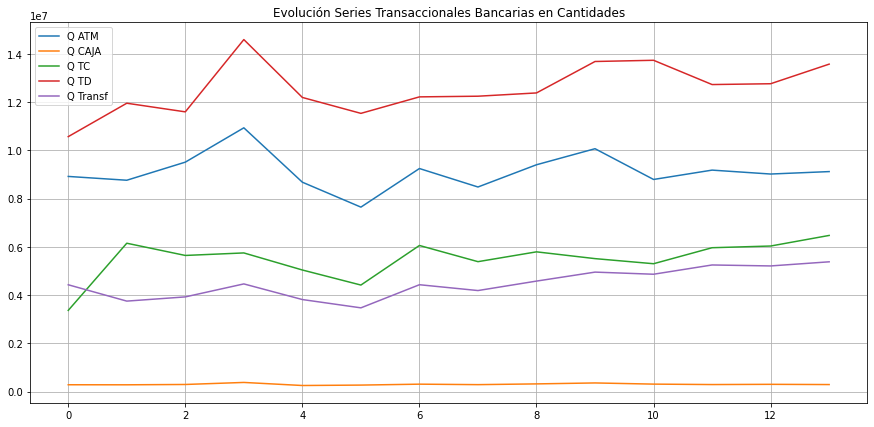

In [28]:
plt.figure(figsize=(15, 7))
plt.plot(trx_agrupmes.Q_ATM, label='Q ATM')
plt.plot(trx_agrupmes.Q_CAJA, label='Q CAJA')
plt.plot(trx_agrupmes.Q_TC, label='Q TC')
plt.plot(trx_agrupmes.Q_TD, label='Q TD')
plt.plot(trx_agrupmes.Q_Transf, label='Q Transf')
plt.title('Evolución Series Transaccionales Bancarias en Cantidades')
plt.grid(True)
plt.legend()
plt.show()

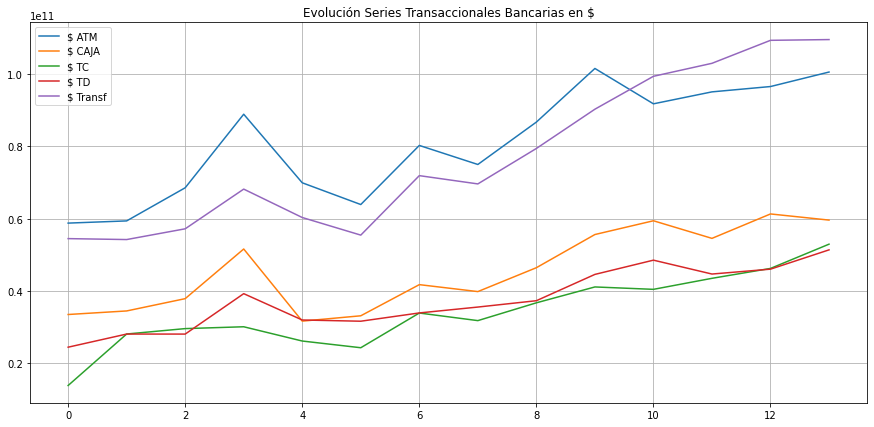

In [29]:
plt.figure(figsize=(15, 7))
plt.plot(trx_agrupmes.S_ATM, label='$ ATM')
plt.plot(trx_agrupmes.S_CAJA, label='$ CAJA')
plt.plot(trx_agrupmes.S_TC, label='$ TC')
plt.plot(trx_agrupmes.S_TD, label='$ TD')
plt.plot(trx_agrupmes.S_Transf, label='$ Transf')
plt.title('Evolución Series Transaccionales Bancarias en $')
plt.grid(True)
plt.legend()
plt.show()

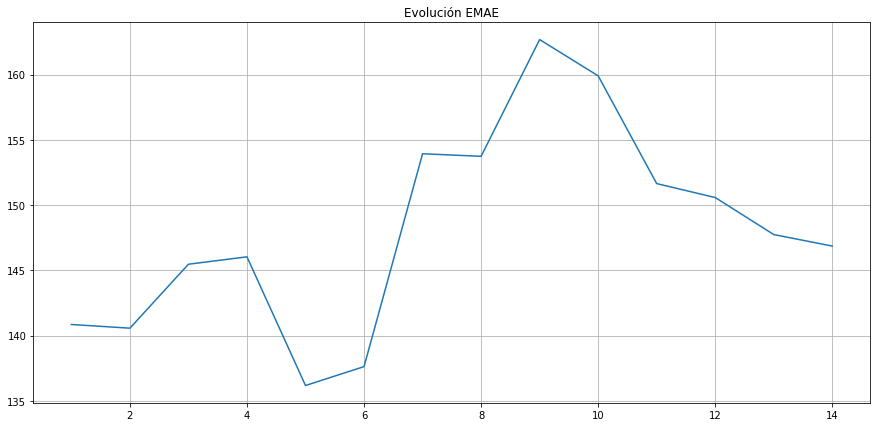

In [30]:
plt.figure(figsize=(15, 7))
plt.plot(emae.Indice)
plt.title('Evolución EMAE')
plt.grid(True)
plt.show()

<Figure size 1080x504 with 0 Axes>

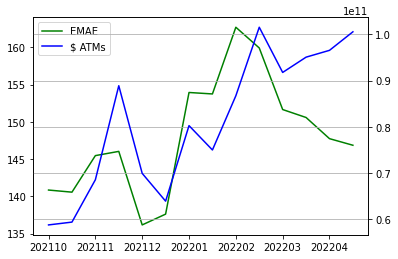

In [31]:
plt.figure(figsize=(15, 7))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(trx_emae.Indice, label='EMAE', color='green')
ax2.plot(trx_emae.S_ATM, label='$ ATMs', color='blue')
plt.grid(True)
lines = ax1.get_lines() + ax2.get_lines()
ax1.set_xticklabels(trx_emae.Periodo)
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')
plt.show()

##  Dickey-Fuller Test

La teoria propone que un proceso estacionario tiene que tener todas sus raices >1.
Lo siguiente de la documentacion de DF me dice que el pvalue es el segundo resultado. Lo llamo con [1]


From:
https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

Returns:  
adf The test statistic.\
pvalue MacKinnon”s approximate p-value based on MacKinnon (1994, 2010).\
usedlag The number of lags used.\
nobsint The number of observations used for the ADF regression and calculation of the critical values. \
critical values  Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010). \
icbest The maximized information criterion if autolag is not None.\


In [35]:
# Como devuelve varios estadisticos, con 1 nos referimos al segundo, esto es, el p-value. Está debajo del umbral así que rechazamos Hipótesis Nula.
sm.tsa.stattools.adfuller(trx_emae.Indice)[1]


8.413394649025133e-14

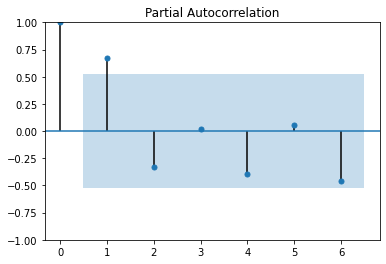

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(trx_emae.Indice, lags=6, alpha=0.05)
plt.show()

In [32]:
# AR(1)
mod = AutoReg(trx_emae.Indice, 1, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                 Indice   No. Observations:                   14
Model:                     AutoReg(1)   Log Likelihood                 -41.318
Method:               Conditional MLE   S.D. of innovations              5.809
Date:                Mon, 23 Jan 2023   AIC                             88.635
Time:                        22:46:50   BIC                             90.330
Sample:                             1   HQIC                            88.287
                                   14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         56.1885     30.314      1.854      0.064      -3.225     115.602
Indice.L1      0.6240      0.204      3.056      0.002       0.224       1.024
                                    Roots           

## Voy a modelar una tendencia y estacionalidad mensual, para intentar llevar la serie a un proceso estacionario 

Propongo primero

$$EMAE_t=\beta_0+\beta_1 t +\beta_1 t^2+ \sum_{m=1}^{11}dmes_m+\epsilon_t $$

In [ ]:
df.head()

,EMAE,EMAERES,EMAETEND
indice_tiempo,,,
1993-01-01,87.389791,-10.032786,99.025500
1993-02-01,85.141646,-13.883853,113.900525
1993-03-01,101.928041,-11.972484,115.062437
1993-04-01,101.890240,-13.172196,120.537692
1993-05-01,103.674974,-16.862718,113.193716


In [ ]:
df['t']=df.reset_index().index
df['t2']=df['t']**2
df['month']=df.index.month
df.head()

,EMAE,EMAERES,EMAETEND,t,t2,month
indice_tiempo,,,,,,
1993-01-01,87.389791,-10.032786,99.025500,0,0,1
1993-02-01,85.141646,-13.883853,113.900525,1,1,2
1993-03-01,101.928041,-11.972484,115.062437,2,4,3
1993-04-01,101.890240,-13.172196,120.537692,3,9,4
1993-05-01,103.674974,-16.862718,113.193716,4,16,5


Utilizo sintaxis de R para facilitar la creacion automatizada de dummies en base a una variable categórica

In [ ]:
pd.get_dummies(df.month)

,1,2,3,4,5,6,7,8,9,10,11,12
indice_tiempo,,,,,,,,,,,,
1993-01-01,1,0,0,0,0,0,0,0,0,0,0,0
1993-02-01,0,1,0,0,0,0,0,0,0,0,0,0
1993-03-01,0,0,1,0,0,0,0,0,0,0,0,0
1993-04-01,0,0,0,1,0,0,0,0,0,0,0,0
1993-05-01,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-01,0,0,0,0,0,0,0,1,0,0,0,0
2013-09-01,0,0,0,0,0,0,0,0,1,0,0,0
2013-10-01,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
pd.concat([df,pd.get_dummies(df.month)], axis=1)

,EMAE,EMAERES,EMAETEND,t,t2,month,1,2,3,4,5,6,7,8,9,10,11,12
indice_tiempo,,,,,,,,,,,,,,,,,,
1993-01-01,87.389791,-10.032786,99.025500,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
1993-02-01,85.141646,-13.883853,113.900525,1,1,2,0,1,0,0,0,0,0,0,0,0,0,0
1993-03-01,101.928041,-11.972484,115.062437,2,4,3,0,0,1,0,0,0,0,0,0,0,0,0
1993-04-01,101.890240,-13.172196,120.537692,3,9,4,0,0,0,1,0,0,0,0,0,0,0,0
1993-05-01,103.674974,-16.862718,113.193716,4,16,5,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-08-01,210.700000,-3.499814,213.490840,247,61009,8,0,0,0,0,0,0,0,1,0,0,0,0
2013-09-01,205.600000,-7.890840,214.769050,248,61504,9,0,0,0,0,0,0,0,0,1,0,0,0
2013-10-01,207.600000,-7.169050,219.256954,249,62001,10,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
model=smf.ols(formula='EMAE~ t+ t2 + C(month)',data=df)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   EMAE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     276.7
Date:                Sat, 15 Oct 2022   Prob (F-statistic):          1.64e-135
Time:                        15:42:08   Log-Likelihood:                -903.27
No. Observations:                 252   AIC:                             1835.
Df Residuals:                     238   BIC:                             1884.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         97.4515      2.502     38.

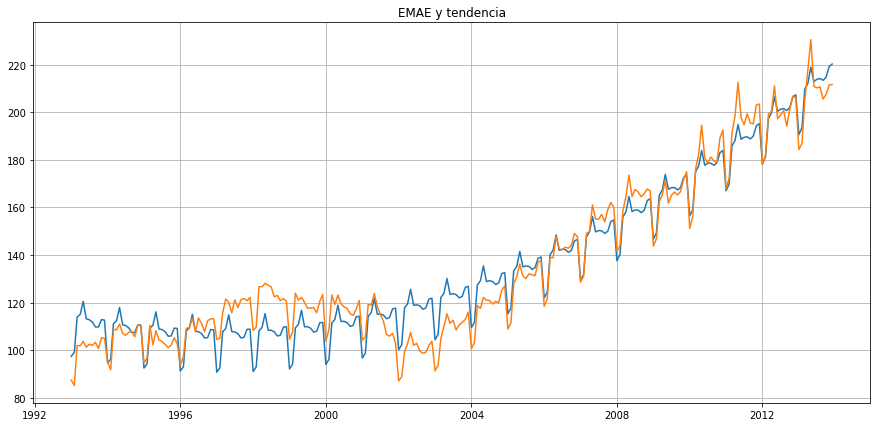

In [ ]:
df['tendencia']=results.predict()
plt.figure(figsize=(15, 7))
plt.plot(df.tendencia)
plt.plot(df.EMAE)
plt.title('EMAE y tendencia')
plt.grid(True)
plt.show()

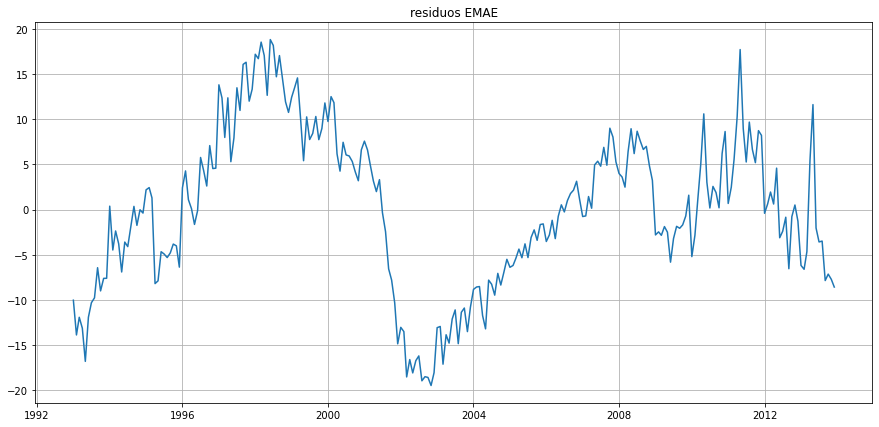

In [ ]:
grafico(results.resid,'residuos EMAE')


Veamos el DF

In [ ]:
sm.tsa.stattools.adfuller(results.resid)[1]

0.19957306298569572

In [ ]:
df['EMAEresid']=results.resid

In [ ]:
# AR(1)
mod = AutoReg(df.EMAEresid, 1, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:              EMAEresid   No. Observations:                  252
Model:                     AutoReg(1)   Log Likelihood                -648.780
Method:               Conditional MLE   S.D. of innovations              3.209
Date:                Sat, 15 Oct 2022   AIC                           1303.561
Time:                        15:42:27   BIC                           1314.137
Sample:                    02-01-1993   HQIC                          1307.817
                         - 12-01-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0082      0.203      0.041      0.968      -0.389       0.405
EMAEresid.L1     0.9291      0.023     39.998      0.000       0.884       0.975
                                    Roots   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
mod = AutoReg(df.EMAEresid, 2, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:              EMAEresid   No. Observations:                  252
Model:                     AutoReg(2)   Log Likelihood                -643.629
Method:               Conditional MLE   S.D. of innovations              3.176
Date:                Sat, 15 Oct 2022   AIC                           1295.258
Time:                        15:42:34   BIC                           1309.344
Sample:                    03-01-1993   HQIC                          1300.927
                         - 12-01-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0272      0.201      0.136      0.892      -0.366       0.421
EMAEresid.L1     0.8088      0.062     12.941      0.000       0.686       0.931
EMAEresid.L2     0.1266      0.062      2.02

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
sm.tsa.stattools.adfuller(res.resid)[1]
# ya podemos rechazar el unit root (i.e. es estacionaria)

0.04847950124779338

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


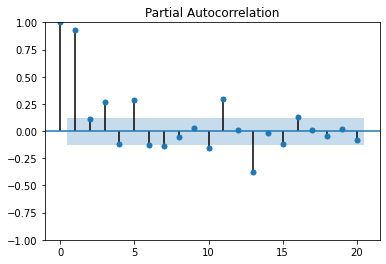

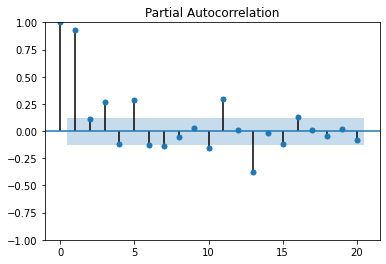

In [ ]:
#smt.graphics.plot_acf(df.EMAEresid, lags=20)
smt.graphics.plot_pacf(df.EMAEresid, lags=20)

In [ ]:
sel = ar_select_order(df.EMAE,maxlag=2, trend='ct',seasonal=True)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   EMAE   No. Observations:                  252
Model:               Seas. AutoReg(2)   Log Likelihood                -646.133
Method:               Conditional MLE   S.D. of innovations              3.208
Date:                Fri, 14 Oct 2022   AIC                           1324.266
Time:                        23:29:05   BIC                           1380.609
Sample:                    03-01-1993   HQIC                          1346.942
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.3622      1.366    -11.976      0.000     -19.040     -13.684
trend          0.0109      0.006      1.774      0.076      -0.001       0.023
s(2,12)       16.8375      1.501     11.215      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:435: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


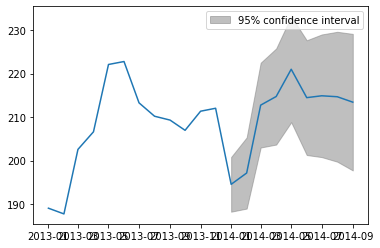

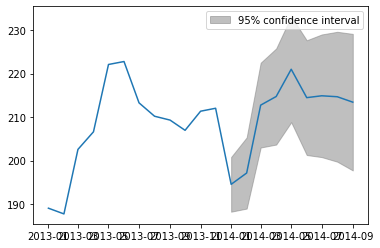

In [ ]:
res.plot_predict(240,260)

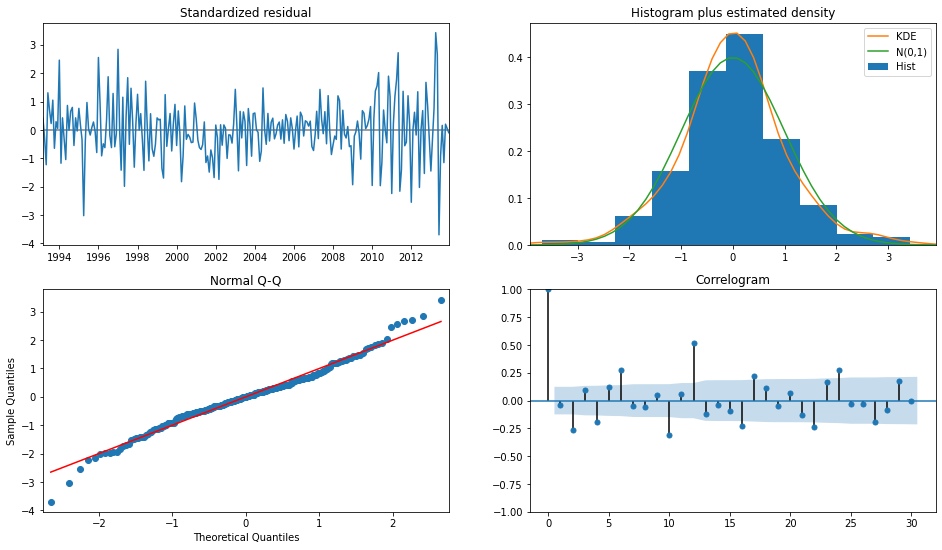

In [ ]:
fig = plt.figure(figsize=(16,9))
fig = res.plot_diagnostics(fig=fig, lags=30)

In [ ]:
sm.tsa.stattools.adfuller((df.EMAE-df.EMAE.shift(1)).dropna(), regresults=True)

(-3.340587112564505,
 0.013158882464738248,
 {'1%': -3.4586084859607156,
  '5%': -2.873972159235721,
  '10%': -2.57339565928848},
 <statsmodels.stats.diagnostic.ResultsStore at 0x7f9e3afc3950>)